<a href="https://colab.research.google.com/github/uxdanaluisa/recomedacao-por-imagens/blob/main/sistemaderecomenda%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3346848866.py:45: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


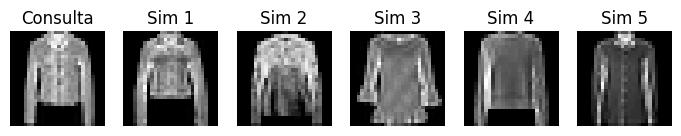

In [1]:
#Sistema de recomdação por imagens


# ---- 1. IMPORTAR BIBLIOTECAS ----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.image import resize
import tensorflow as tf

# ---- 2. CARREGAR DATASET ----
# Fashion-MNIST: 10 classes de roupas, 60k imagens 28x28
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Vamos usar **menos imagens** para economizar RAM
x_train = x_train[:2000]  # 2000 imagens para treino
x_test  = x_test[:50]     # 50 imagens para teste

# Converter para RGB e normalizar [0,1]
x_train = np.stack([x_train]*3, axis=-1) / 255.0
x_test  = np.stack([x_test]*3,  axis=-1) / 255.0

# ---- 3. FUNÇÃO PARA REDIMENSIONAR E PREPROCESSAR IMAGENS EM LOTES ----
def preprocess_images_in_batches(imgs, batch_size=100):
    """
    Redimensiona para 224x224 e aplica preprocess_input do MobileNet
    Processa em lotes para economizar memória
    """
    imgs_resized = []
    num_batches = int(np.ceil(len(imgs)/batch_size))
    for i in range(num_batches):
        batch = imgs[i*batch_size:(i+1)*batch_size]
        batch_resized = tf.image.resize(batch, (224,224))
        batch_resized = preprocess_input(batch_resized)
        imgs_resized.append(batch_resized.numpy())
    return np.concatenate(imgs_resized, axis=0)

x_train_resized = preprocess_images_in_batches(x_train, batch_size=200)
x_test_resized  = preprocess_images_in_batches(x_test, batch_size=20)

# ---- 4. EXTRAIR EMBEDDINGS COM MobileNetV2 (sem camada final) ----
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Processar em lotes para economizar memória
def extract_embeddings(model, imgs, batch_size=32):
    embeddings = []
    num_batches = int(np.ceil(len(imgs)/batch_size))
    for i in range(num_batches):
        batch = imgs[i*batch_size:(i+1)*batch_size]
        emb = model.predict(batch, verbose=0)
        embeddings.append(emb)
    return np.concatenate(embeddings, axis=0)

embeddings_train = extract_embeddings(base_model, x_train_resized, batch_size=32)
embeddings_test  = extract_embeddings(base_model, x_test_resized, batch_size=16)

# ---- 5. AJUSTAR MODELO DE VIZINHOS MAIS PRÓXIMOS ----
nbrs = NearestNeighbors(n_neighbors=6, algorithm='auto', metric='euclidean')
nbrs.fit(embeddings_train)

# ---- 6. FUNÇÃO DE RECOMENDAÇÃO ----
def recomendar(imagem_indice):
    """
    Mostra a imagem de teste e as 5 imagens mais parecidas do treino
    """
    emb = embeddings_test[imagem_indice].reshape(1, -1)
    distancias, indices = nbrs.kneighbors(emb)

    # Plotar a imagem de consulta
    plt.figure(figsize=(10,2))
    plt.subplot(1,7,1)
    plt.imshow(x_test[imagem_indice].astype("float"))
    plt.title("Consulta")
    plt.axis("off")

    # Plotar as 5 mais parecidas
    for i, idx in enumerate(indices[0][1:]):
        plt.subplot(1,7,i+2)
        plt.imshow(x_train[idx].astype("float"))
        plt.title(f"Sim {i+1}")
        plt.axis("off")
    plt.show()

# ---- 7. TESTAR O SISTEMA ----
recomendar(10)  # Escolha uma imagem de teste entre 0 e 49


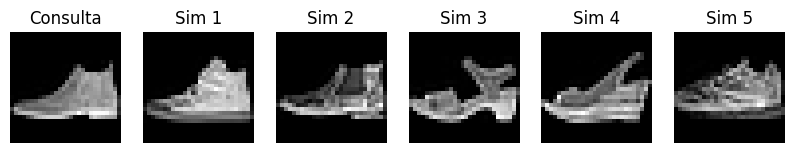

In [2]:
# ==============================================
# SISTEMA DE RECOMENDAÇÃO POR IMAGENS LEVE
# Sem redes grandes, roda rápido no Colab gratuito
# ==============================================

# ---- 1. IMPORTAR BIBLIOTECAS ----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.datasets import fashion_mnist

# ---- 2. CARREGAR DATASET ----
# Usaremos só uma parte pequena para evitar travar
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train[:500]  # apenas 500 imagens de treino
x_test  = x_test[:10]    # apenas 10 imagens de teste

# Normalizar para [0,1]
x_train = x_train / 255.0
x_test  = x_test / 255.0

# ---- 3. FLATTEN (achatar as imagens 28x28 para 784 pixels) ----
X_train_flat = x_train.reshape(len(x_train), -1)  # 500 x 784
X_test_flat  = x_test.reshape(len(x_test), -1)    # 10 x 784

# ---- 4. AJUSTAR MODELO DE VIZINHOS MAIS PRÓXIMOS ----
nbrs = NearestNeighbors(n_neighbors=6, metric='euclidean')
nbrs.fit(X_train_flat)

# ---- 5. FUNÇÃO DE RECOMENDAÇÃO ----
def recomendar(imagem_indice):
    """
    Mostra a imagem de teste e as 5 imagens mais parecidas do treino
    """
    emb = X_test_flat[imagem_indice].reshape(1, -1)
    distancias, indices = nbrs.kneighbors(emb)

    plt.figure(figsize=(10,2))

    # Imagem de consulta
    plt.subplot(1,6,1)
    plt.imshow(x_test[imagem_indice], cmap='gray')
    plt.title("Consulta")
    plt.axis("off")

    # As 5 mais parecidas
    for i, idx in enumerate(indices[0][1:]):  # pular o mais próximo (ele mesmo)
        plt.subplot(1,6,i+2)
        plt.imshow(x_train[idx], cmap='gray')
        plt.title(f"Sim {i+1}")
        plt.axis("off")

    plt.show()

# ---- 6. TESTAR O SISTEMA ----
recomendar(0)  # escolhe índice entre 0 e 9
